In [1]:
from __future__ import print_function
from ctypes import CFUNCTYPE, c_double
import llvmlite.binding as llvm
import ast
import astor 
import showast
import codegen
from numba import jit
import sys
import re
import os
from pprint import pprint
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'


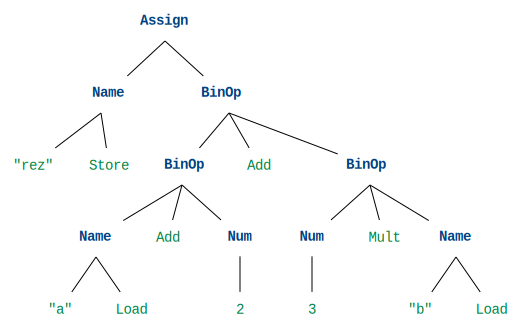

In [2]:
%%showast
rez = a+2+3*b

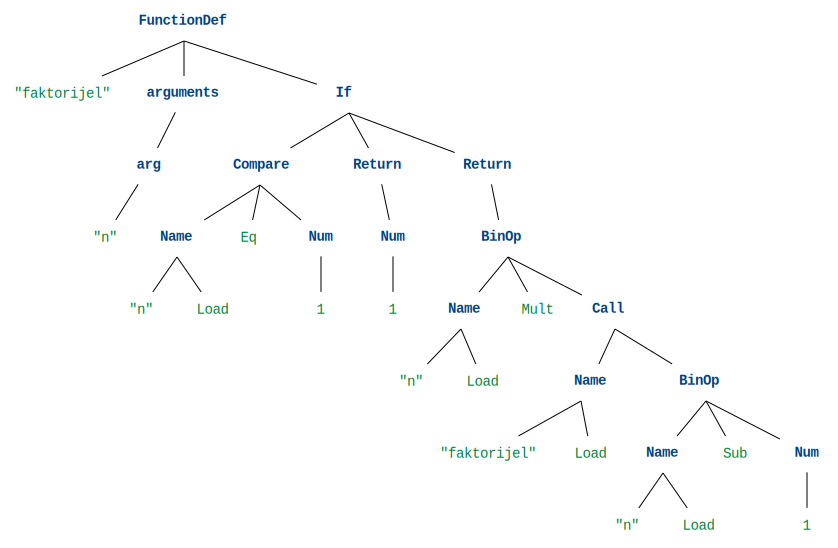

In [3]:
%%showast
def faktorijel(n):
    if(n == 1):
        return 1
    else:
        return n * faktorijel(n - 1)

In [4]:
#Od strane 3: http://poincare.matf.bg.ac.rs/~jelenagr/rs2/DP5.pdf

class Node:
    pass

class UnaryOperator(Node):
    def __init__(self, operand):
        self.operand = operand

class BinaryOperator(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOperator):
    pass

class Sub(BinaryOperator):
    pass

class Mul(BinaryOperator):
    pass

class Div(BinaryOperator):
    pass

class Negate(UnaryOperator):
    pass

class Number(Node):
    def __init__(self, value):
        self.value = value
class NodeVisitor:
    def visit(self, node, way):
        methname = 'visit_' + type(node).__name__ + '_'+ way
       
        meth = getattr(self, methname, None)
        if meth is None:
            meth = self.generic_visit
    
        return meth(node)

    def generic_visit(self, node):
        raise RuntimeError('No {} method'.format('visit_' + type(node).__name__))

class StackCode(NodeVisitor):
    
    def __init__(self, way):
        self.way = way
    
    def generate_code(self, node):
        self.instructions = []
        self.visit(node, self.way)
        return self.instructions

    def visit_Number_postfix(self, node):
        self.instructions.append(('PUSH', node.value))

    def visit_Add_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('ADD',))

    def visit_Sub_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('SUB',))

    def visit_Mul_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('MUL',))

    def visit_Div_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('DIV',))

    def visit_Negate_postfix(self, node):
        self.visit(node.operand, self.way)
        self.instructions.append(('NEG',))
     
    def visit_Number_postfix(self, node):
        self.instructions.append(('PUSH', node.value))

    def visit_Add_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('ADD',))
        self.visit(node.right, self.way)
        
    def visit_Sub_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('SUB',))
        self.visit(node.right, self.way)
        

    def visit_Mul_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('MUL',))
        self.visit(node.right, self.way)

    def visit_Div_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('DIV',))
        self.visit(node.right, self.way)
        

    def visit_Negate_infix(self, node):
        self.visit(node.operand, self.way)
        self.instructions.append(('NEG',))
        
    def visit_Number_infix(self, node):
        self.instructions.append(('PUSH', node.value))
        

    def visit_Add_prefix(self, node):
        self.instructions.append(('ADD',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        
    def visit_Sub_prefix(self, node):
        self.instructions.append(('SUB',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        

    def visit_Mul_prefix(self, node):
        self.instructions.append(('MUL',))
        self.visit(node.left, self.way) 
        self.visit(node.right, self.way)

    def visit_Div_prefix(self, node):
        self.instructions.append(('DIV',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        

    def visit_Negate_prefix(self, node):
        self.instructions.append(('NEG',))
        self.visit(node.operand, self.way)
        
    def visit_Number_prefix(self, node):
        self.instructions.append(('PUSH', node.value))
        
t1 = Sub(Number(3), Number(4))
t2 = Mul(Number(2), t1)
t3 = Div(t2, Number(5))
t4 = Add(Number(1), t3)
print("ispisujemo infiksno Levo -> Koren -> Desno")
s = StackCode("infix")
code = s.generate_code(t2)
for c in code:
    print(c)
    
print("\n\n Ispisujemo postfiksno Levo -> Desno -> Koren")
s = StackCode("postfix")
code = s.generate_code(t2)
for c in code:
    print(c)


print("\n\n Ispisujemo prefiksno Koren -> Levo -> Desno")
s = StackCode("prefix")
code = s.generate_code(t2)
for c in code:
    print(c)

    
    


ispisujemo infiksno Levo -> Koren -> Desno
('PUSH', 2)
('MUL',)
('PUSH', 3)
('SUB',)
('PUSH', 4)


 Ispisujemo postfiksno Levo -> Desno -> Koren
('PUSH', 2)
('PUSH', 3)
('PUSH', 4)
('SUB',)
('MUL',)


 Ispisujemo prefiksno Koren -> Levo -> Desno
('MUL',)
('PUSH', 2)
('SUB',)
('PUSH', 3)
('PUSH', 4)


In [5]:
import ast

def dump(obj):
    for attr in dir(obj):
        print("obj.%s = %r" % (attr, getattr(obj, attr)))

try:
    with open("fajl.txt", "r") as f:
        data = f.read()
except IOError:
    sys.exit("Nije uspeo da otvori fajl")

p = ast.parse(data)
print("Module object ==> {}".format(p))
exec(compile(p, filename="<ast>", mode="exec"))



Module object ==> <_ast.Module object at 0x0000026352752EB8>
Zdravo svete!
i ovo moze


In [37]:
# llvm => https://www.rt-rk.uns.ac.rs/sites/default/files/Aleksandar%20Beserminji,%20master%20rad.pdf
# ovo moze da bude nesto dobro: https://llvmlite.readthedocs.io/en/latest/user-guide/binding/examples.html
# Treba pogledati => https://github.com/yuri91/brainfuck-jit/tree/d9278f8300634428b8e1442ab694ae013c5c2ace
# Vrlo korisno https://eli.thegreenplace.net/2015/calling-back-into-python-from-llvmlite-jited-code/

from llvmlite import ir
import ast
from collections import deque
import sys, re, os
import llvmlite.binding as llvm
from ctypes import CFUNCTYPE
import cs50
import math
from prestans import types
from ctypes import *

#ovo je neophodno kako bismo mogli da izvrsimo medjukod
llvm.initialize()
llvm.initialize_native_target()
llvm.initialize_native_asmprinter()


def create_execution_engine():
    """
    Create an ExecutionEngine suitable for JIT code generation on
    the host CPU.  The engine is reusable for an arbitrary number of
    modules.
    """
    # Create a target machine representing the host
    target = llvm.Target.from_default_triple()
    target_machine = target.create_target_machine()
    # And an execution engine with an empty backing module
    backing_mod = llvm.parse_assembly("")
    engine = llvm.create_mcjit_compiler(backing_mod, target_machine)
    return engine


def compile_ir(engine, llvm_ir):
    """
    Compile the LLVM IR string with the given engine.
    The compiled module object is returned.
    """
    # Create a LLVM module object from the IR
    mod = llvm.parse_assembly(llvm_ir)
    mod.verify()
    # Now add the module and make sure it is ready for execution
    engine.add_module(mod)
    engine.finalize_object()
    engine.run_static_constructors()
    return mod


class ast_parse_llvmir:

    def __init__(self):
        # mapa promenjivih, kljuc -> naziv promenjive; vrednost -> alocirana promenjiva
        self.vars = {}
        # self.fn je lista (stek) funkcija. Svaki put kada udjemo u novu funkcju, u stek dodamo tu funkciju
        # kada u telu funkcije pristupamo npr. dodeli prvo dohvatamo trenutnu funkciju u kojoj je nastala dodela
        # to radimo tako sto dohvatamo self.fn[-1] (poslednji element liste)
        self.fn = []
        # isto sto vazi za fn, vazi i za builders
        self.builders = []
        # self.lista je privremena lista koja sluzi da u nju stavimo izraz u prilikom dodele ili returna
        # pravi je funkcija create_list
        self.lista = []
        # string koji se egzekjutuje i pravi (dodelu ili return)
        self.tmp = """"""
        # lista promenjivih koja se pamti u naredbama dodele i return-a
        self.tmp_vars = []
        # lista funkcija i njihovih argumenata
        self.funkcije_argumenti = []
        # recnik ir funkcija spremnih za prevodjenje; key = ime_funkcije; value = fn
        self.lista_spremnih = {}
        # promenjiva koja pamti da li se ispisuje funkcija:
        self.funkcija_ispis = 0
        # ubacujemo i ir.module()
        self.m = ir.Module()

    def mapiraj(self, op):
        #ako je promenjiva op aritmeticki operator, nalazi se u mapi
        #ova funkcija sluzi da prebacimo npr "Gt" u '>' jer nam je za funkciju
        #builder.icmp_signed potreban zapis u tom obliku
        mapa = {
            'LtE': '<=',
            'Lt': '<',
            'GtE': '>=',
            'Gt': '>',
            'Eq': '==',
            'NotEq': '!='
        }
        if (op in mapa):
            return mapa[op]
        else:
            #ako operator ne postoji u Mapi vracamo None, sto cemo posle da obradimo. 
            #Odnosno operator nije validan
            return None

    def callFun(self, node):
        #izvlacimo broj argumenata funkcije
        num_of_vars = len(node.args.args)
        lista = []
        
        #u listu ubacujemo tipove tih argumenata (po default-u su int)
        for i in range(num_of_vars):
            lista.append(ir.IntType(32))
        fnty = ir.FunctionType(ir.IntType(32), lista)
        #dobijamo zaglavlje funkcije
        fn = ir.Function(self.m, fnty, node.name)
        #smestamo f-ju u listu svih f-ja
        self.fn.append(fn)
        
        #pravimo builder
        builder = ir.IRBuilder(fn.append_basic_block('entry'))
        self.builders.append(builder)
        
        for i in range(len(self.funkcije_argumenti)):
            if (node.name not in self.funkcije_argumenti[i][0]):
                return
            else:
                if (self.funkcije_argumenti[i][0] == node.name):
                    broj_fun = i
                    break
        #popunjavamo zaglavlje funkcije sa nazivima argumenata
        for i in range(num_of_vars):
            fn.args[i].name = node.args.args[i].arg
            self.vars[node.args.args[i].arg] = fn.args[i]

        # obilazimo telo funkcije rekurzivno! Koristim func_pass funkciju umesto visitor-a
        # samo jer ne zelimo da on obilazi detaljno if 
        for i in range(len(node.body)):
            self.func_pass(node.body[i])

        # izbacujemo sve promenjive ove funkcije iz self.vars
        self.vars = {}

        self.lista_spremnih[node.name] = fn
        # izbacujemo funkciju jer je zavrsavamo 
        self.fn.pop(-1)
        self.builders.pop(-1)
        # izbacujemo poziv te funkcije jer smo ga zavrsili
        del self.funkcije_argumenti[broj_fun]
        # brisemo i duplikat
        del self.funkcije_argumenti[broj_fun]
        
        #ispisujemo medjukodnu reprezentaciju f-je
        print(fn, end="")
        print('\n')
        if (len(self.fn) == 0):
            return -1
        else:
            return 0
        
        
    #ovu metodu pozivamo kada udjemo u if node
    #ona prolazi rekurzivno kroz "if stablo" i stavlja redom elemente u listu
    #kada funkcija zavrsi sa radom u self.lista uneseni su svi elementi u listu
    # primer self.lista nakon zavrsetka metode = ['Gt', 'n', '12'] <==> if(n > 12)
    def create_if_list(self, node):
        
        #uzima operand
        if (hasattr(node, 'op') == True):
            root = node.op.__class__.__name__
            self.lista.append(root)
        #uzima operande
        if (hasattr(node, 'ops') == True):
            for j in range(len(node.ops)):
                root = node.ops[j].__class__.__name__
                self.lista.append(root)
        #zove rekurzivno za levo podstablo
        if (hasattr(node, 'left') == True):
            self.create_if_list(node.left)
            
        #zove rekurzivno za desno podstablo
        if (hasattr(node, 'right') == True):
            self.create_if_list(node.right)

        #uzima komparator (Gt, Eq, itd...)
        if (hasattr(node, 'comparators') == True):
            for i in range(len(node.comparators)):
                self.create_if_list(node.comparators[i])
                
        #krece se rekurizvno
        if (hasattr(node, 'values') == True):
            for i in range(len(node.values)):
                self.create_if_list(node.values[i])

        #uzima vrednost (int) ili promenjivu(takodje moze i argument)
        if ((hasattr(node, 'right') == False) and (hasattr(node, 'left') == False)):
            if (hasattr(node, 'n')):
                atribut = node.n
                self.lista.append(atribut)
            elif (hasattr(node, 'id')):
                atribut = node.id
                self.lista.append(atribut)
                
                
    
    def callIf(self, node):
        # iz liste ubacujem u lokalnu varijablu da bi IF znao kojoj f-ji pripada
        fn = self.fn[-1]
        builder = self.builders[-1]
        #u promenjivu tmp ubacujemo self.tmp ako nije nastala neka greska
        tmp = """pred = """
        #pravimo self.list
        self.create_if_list(node.test)
        #na osnovu self.list pravi se string koji se smesta u tmp
        if (self.izListeUString(0) != -1):
            tmp += self.tmp
        else:
            return -1
        #pravimo tri bloka, zaglavlje telo i posle if-a
        if_block = builder.append_basic_block('if')
        then_block = builder.append_basic_block('then')
        end_block = builder.append_basic_block('end_if')
        #ubacujemo ostatak u tmp
        tmp += "\n"
        tmp += """
builder.branch(if_block)
builder.position_at_end(if_block)
# implement if_block
builder.cbranch(pred, then_block, end_block)
        """
        
        #izvrsavamo tmp kao i u prethodnoj celiji
        exec(tmp)
        
        #praznimo promenjive koje smo koristili
        self.tmp = ""
        self.lista = []

        # Ako prodje if, poziva se rekurzivno za body if-a
        builder.position_at_end(then_block)
        for i in range(len(node.body)):
            self.ast_visit(node.body[i])

        #nakon toga se u svakom slucaju pozicioniramo na end_if-a
        builder.position_at_end(end_block)
        return 0

    def create_list(self, node):

        if (hasattr(node, 'op') == True):
            root = node.op.__class__.__name__
            self.lista.append(root)

        if ((hasattr(node, 'right') == False) and (hasattr(node, 'left') == False)):
            if (hasattr(node, 'n')):
                atribut = node.n
            else:
                atribut = node.id
            self.lista.append(atribut)

        if (hasattr(node, 'left') == True):
            self.create_list(node.left)

        if (hasattr(node, 'right') == True):
            self.create_list(node.right)

    def izListeUString(self, i):
        fn = self.fn[-1]

        if (self.lista[i] == 'Add'):
            self.tmp += "builder.add("
            # promenjiva poslednji dohvata poslednji element iz liste koji pripada prvom operandu trenutnog Add-a
            poslednji = self.izListeUString(i + 1)
            self.tmp += ", "
            poslednji = self.izListeUString(int(poslednji) + 1)
            self.tmp += ")"
            return poslednji
        elif (self.lista[i] == 'Mult'):
            self.tmp += "builder.mul("
            # promenjiva poslednji dohvata poslednji element iz liste koji pripada prvom operandu trenutnog Mul-a
            poslednji = self.izListeUString(i + 1)
            self.tmp += ", "
            poslednji = self.izListeUString(int(poslednji) + 1)
            self.tmp += ")"
            return poslednji

        elif (self.lista[i] == 'And'):
            self.tmp += "builder.and_("
            # self.tmp += '\n'
            # promenjiva poslednji dohvata poslednji element iz liste koji pripada prvom operandu trenutnog And-a
            poslednji = self.izListeUString(i + 1)
            self.tmp += ", "
            poslednji = self.izListeUString(int(poslednji) + 1)
            self.tmp += ")"
            return poslednji

        elif (self.lista[i] == 'Or'):
            self.tmp += "builder.or_("
            # self.tmp += '\n'
            # promenjiva poslednji dohvata poslednji element iz liste koji pripada prvom operandu trenutnog Or-a
            poslednji = self.izListeUString(i + 1)
            self.tmp += ", "
            poslednji = self.izListeUString(int(poslednji) + 1)
            self.tmp += ")"
            return poslednji

        elif (self.mapiraj(self.lista[i]) != None):
            op = self.mapiraj(self.lista[i])
            self.tmp += "builder.icmp_signed( '" + op + "', "
            # self.tmp += '\n'
            # promenjiva poslednji dohvata poslednji element iz liste koji pripada prvom operandu trenutnog compare-a
            poslednji = self.izListeUString(i + 1)
            self.tmp += ", "
            poslednji = self.izListeUString(int(poslednji) + 1)
            self.tmp += ")"
            return poslednji
        else:

            if (isinstance(self.lista[i], int)):
                broj = str(self.lista[i])
                self.tmp += ("ir.Constant(ir.IntType(32), " + broj + ")")
            elif (self.lista[i] in self.vars):
                if (self.lista[i] not in (fn.args[j].name for j in range(len(fn.args)))):
                    self.tmp_vars.append(self.vars[self.lista[i]][0])
                    j = len(self.tmp_vars) - 1
                    self.tmp += "builder.load(self.tmp_vars[" + str(j) + "])"
                else:
                    for j in range(len(fn.args)):
                        if (self.lista[i] == fn.args[j].name):
                            indeks = j
                    self.tmp += "self.fn[-1].args[" + str(indeks) + "]"

            else:
                print("GRESKA, koristis promenjivu u dodeli koja nije prethodno inicijalizovana: {}".format(
                    self.lista[i]))
                return -1

            return i

    def callAssign(self, node):
        # pravimo listu koja sadrzi operacije i operande npr. ['Mult', 24, 'm'] (ovo je zapravo 14*m)
        self.create_list(node.value)

        # ovako mora da pocne assign. radimo Store u promenjivu.
        tmp = """builder.store("""

        # proveravamo da li je metoda uspela da izgenerise string za nas. Ako je npr naisla
        # na promenjivu koja nije definisana u trenutnoj funkciji,
        # treba da vrati -1, izbaci nas iz funkcije i zavrsi izvrsavanje.
        if (self.izListeUString(0) != -1):
            tmp += self.tmp
        else:
            return -1

        # dohvatamo promenjivu u koju storujemo vrednost izraza sa desne strane znaka '='
        p = node.targets[0].id

        # dohvatamo trenutni builder kako bismo mogli da alociramo (definisemo) promenjivu
        builder = self.builders[-1]

        # dohvatamo trenutni builder kako bismo mogli da alociramo (definisemo) promenjivu ako nije vec deklarisana.
        #ako jeste onda prosto uzimamo tu vec definisanu promenjivu
        if(p not in self.vars):
            promenjiva = builder.alloca(ir.IntType(32), name=p)
            tmp += ', ' + 'promenjiva' + ')'
        else:
            promenjiva = self.vars[p][0]
            tmp += ', ' + 'promenjiva' + ')'

        exec(tmp)

        # praznimo liste i stringove koje cemo ponovo da koristimo u narednoj dodeli ili return-u
        self.tmp = """"""
        self.lista = []
        self.tmp_vars = []

        # ubacujemo novu promenjivu u recnik promenjivih
        self.vars[p] = (promenjiva, self.builders.index(builder))

    def callReturn(self, node):
        builder = self.builders[-1]
        #pravimo listu od izraza primer liste -> ['Mult', 'a', 15] <==> a*15
        self.create_list(node.value)
        # ovako mora da pocne return, append-ujemo self.tmp na string tmp
        tmp = """builder.ret("""
        if (self.izListeUString(0) != -1):
            tmp += self.tmp
        else:
            return -1
        tmp += ')'

        #izvrsavamo tmp (odnosno string tmp ce da se izvrsi kao python kod)
        exec(tmp)
        
        #praznimo polja koja cemo ponovo da koristimo
        self.tmp = """"""
        self.lista = []
        self.tmp_vars = []
        

    def callCall(self, node):
        
        argumenti = []
        #ovaj prefiks je neophodan kako bi se medjukod izvrsio
        llvm_ir = """
           ; ModuleID = "examples/ir_fpadd.py"
           target triple = "unknown-unknown-unknown"
           target datalayout = ""
        """
        # pronalazimo sve argumente f-je i stavljamo u listu
        for i in range(len(node.args)):
            arg = node.args[i].n
            argumenti.append(arg)

        # dohvatamo naziv i proveravamo da li je fj-a prethodno prevedena u medjukod
        naziv_fun = node.func.id
        if (naziv_fun in self.lista_spremnih):
            llvm_ir += str(self.lista_spremnih[naziv_fun])
        else:
            print("pozivas funkciju koju prethodno nisi napravio")
            return -1

        engine = create_execution_engine()

        mod = compile_ir(engine, llvm_ir) 

        # dohvatamo argumente funkcije
        argumenti_brojevi = ""
        if (len(node.args) != 0):
            for i in range(len(node.args) - 1):
                argumenti_brojevi += str(argumenti[i]) + ", "
            argumenti_brojevi += str(argumenti[-1]) + ")"
        else:
            argumenti_brojevi = ")"
        #string prec postavljamo kako nam odgovara da bismo ga izvrsili
        prec = """
func_ptr = engine.get_function_address(naziv_fun)
cfunc = CFUNCTYPE(ctypes.c_int32, ctypes.c_int32) (func_ptr) 
rezultat = cfunc("""
        prec += argumenti_brojevi
        prec += "\n"
        prec += "print(rezultat)"
        print(naziv_fun + "(" + argumenti_brojevi + "= ", end=" ")
        #izvrsavamo string prec, on nam vraca rezultat funkcije.
        exec(prec)
        
    #metoda koja proverava kog tipa je node i u skladu sa tim poziva potrebnu funkciju
    def str_node(self, node):
        if isinstance(node, ast.AST):
            fields = [(name, self.str_node(val)) for name, val in ast.iter_fields(node) if
                      name not in ('left', 'right')]
            if (node.__class__.__name__ == 'FunctionDef'):

                provera = self.callFun(node)
                if (provera == -1):
                    return -1
            elif (node.__class__.__name__ == 'If'):
                provera = self.callIf(node)
                if (provera == -1):
                    return -1

            elif (node.__class__.__name__ == "Assign"):
                provera = self.callAssign(node)
                if (provera == -1):
                    return -1
            elif (node.__class__.__name__ == "Call"):
                self.funkcija_ispis += 1
                if (self.funkcija_ispis % 2 == 1):
                    provera = self.callCall(node)
                    if (provera == -1):
                        return -1
                else:
                    pass
            elif (node.__class__.__name__ == "Return"):
                provera = self.callReturn(node)
                if (provera == -1):
                    return -1
            else:
                rv = '%s(%s' % (node.__class__.__name__, ', '.join('%s=%s' % field for field in fields))
                # print(rv)
        else:
            return 0

    
    def ast_visit(self, node):
        provera = self.str_node(node)
        if (provera == -1):
            return -1
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        self.ast_visit(item)
            elif isinstance(value, ast.AST):
                self.ast_visit(value)

    def str_node_calls(self, node):
        if isinstance(node, ast.AST):
            fields = [(name, self.str_node_calls(val)) for name, val in ast.iter_fields(node) if
                      name not in ('left', 'right')]
            if (node.__class__.__name__ == 'Call'):
                argumenti = []
                for i in range(len(node.args)):
                    arg = node.args[i].n
                    argumenti.append(arg)
                naziv_fun = node.func.id
                self.funkcije_argumenti.append([naziv_fun, argumenti])
            else:
                rv = '%s(%s' % (node.__class__.__name__, ', '.join('%s=%s' % field for field in fields))
                # print(rv)
        else:
            return 0

    def first_pass(self, node):
        self.str_node_calls(node)
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        self.first_pass(item)
            elif isinstance(value, ast.AST):
                self.first_pass(value)

    def func_pass(self, node):
        self.str_node(node)
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if(node.__class__.__name__ == 'If'):
                        pass
                    elif(isinstance(item, ast.AST)):
                        self.func_pass(item)
            elif isinstance(value, ast.AST):
                self.func_pass(value)


string = """

def f(n, d):
    m = 0
    if(n+d > 12*4 or n > d):
        m = 5
        return  n  + d + m
    m = 12
    return m 



f(56, 55)
f(1, 12)

"""

parsiran = ast.parse(string)

g = ast_parse_llvmir()
g.first_pass(parsiran)
g.ast_visit(parsiran)

define i32 @"f"(i32 %"n", i32 %"d") 
{
entry:
  %"m" = alloca i32
  store i32 0, i32* %"m"
  %".5" = add i32 %"n", %"d"
  %".6" = mul i32 12, 4
  %".7" = icmp sgt i32 %".5", %".6"
  %".8" = icmp sgt i32 %"n", %"d"
  %".9" = or i1 %".7", %".8"
  br label %"if"
if:
  br i1 %".9", label %"then", label %"end_if"
then:
  store i32 5, i32* %"m"
  %".13" = add i32 %"n", %"d"
  %".14" = load i32, i32* %"m"
  %".15" = add i32 %".13", %".14"
  ret i32 %".15"
end_if:
  store i32 12, i32* %"m"
  %".18" = load i32, i32* %"m"
  ret i32 %".18"
}


f(56, 55)=  116
f(1, 12)=  12


U celiji iznad napisana je klasa koja radi sa funkcijama i pozivima funkcija.
Prihvata parsiran tekst, prolazi kroz cvorove i prvo pravi medjukod, a zatim taj medjukod izvrsava.


In [9]:
import ast
def str_node(node):
    if isinstance(node, ast.AST):
        fields = [(name, str_node(val)) for name, val in ast.iter_fields(node) if name not in ('left', 'right')]
        rv = '%s(%s' % (node.__class__.__name__, ', '.join('%s=%s' % field for field in fields))
        print( rv + ')')
    else:
        return repr(node)
def ast_visit(node, level=0):
    
    str_node(node)
    for field, value in ast.iter_fields(node):
        if isinstance(value, list):
            for item in value:
                if isinstance(item, ast.AST):
                    ast_visit(item, level=level+1)
                    pass
        elif isinstance(value, ast.AST):
            ast_visit(value, level=level+1)
            
def func_pass(node):
    str_node(node)
    for field, value in ast.iter_fields(node):
        if isinstance(value, list):
            for item in value:
                if(node.__class__.__name__ == 'If'):
                    pass
                elif(isinstance(item, ast.AST)):
                    func_pass(item)
        elif isinstance(value, ast.AST):
            func_pass(value)

            
            

stro55 = """
def f(n, d):
    m = 0
    if(n+d > 12*4 or n > d):
        m = 5
        return  n  + d + m
    m = 12
    return m 
"""


func_pass(ast.parse(stro55))

Module(body=[<_ast.FunctionDef object at 0x0000026352ED8C18>])
arguments(args=[<_ast.arg object at 0x0000026352ED8BA8>, <_ast.arg object at 0x0000026352ED8C50>], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[])
FunctionDef(name='f', args=None, body=[<_ast.Assign object at 0x0000026352ED8CC0>, <_ast.If object at 0x0000026352ED8E10>, <_ast.Return object at 0x0000026352ED8A58>], decorator_list=[], returns=None)
arguments(args=[<_ast.arg object at 0x0000026352ED8BA8>, <_ast.arg object at 0x0000026352ED8C50>], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[])
arg(arg='n', annotation=None)
arg(arg='druga', annotation=None)
Add()
BinOp(op=None)
Assign(targets=[<_ast.Name object at 0x0000026352ED8D68>], value=None)
Store()
Name(id='m', ctx=None)
Store()
Add()
BinOp(op=None)
Mult()
BinOp(op=None)
Num(n=12)
Mult()
Load()
Name(id='n', ctx=None)
Load()
Add()
Num(n=5)
And()
BoolOp(op=None, values=[<_ast.Compare object at 0x0000026352ED8E48>, <_ast.Compare obje